# Classification Analysis

This Jupyter notebook demonstrates a classification analysis using various machine learning models, ranging from tree-based algorithms to deep learning techniques.

## Overview

- **Data Sources**: 
  - For tree-based models, we use `patient_data_onehot_imputed.pkl`, which requires minimal data preparation.
  - For models where distances are crucial, such as those that rely on numerical relationships, we use `machine_learning_patient_data.pkl`, which includes all necessary pre-processing.

- **Model Optimization**:  
  - GridSearch is applied to optimize each model’s hyperparameters, aiming for the best performance.

- **Evaluation Metrics**:  
  - Each model is evaluated using the following metrics:
    - **Accuracy**: Measures the overall correctness of the model.
    - **Recall**: Focuses on capturing all relevant cases.
    - **Precision**: Indicates how precise the model’s positive predictions are.
    - **F1 Score**: Balances precision and recall into a single metric.
    - **AUC (Area Under the ROC Curve)**: Reflects the model's ability to distinguish between classes.

This comprehensive approach ensures we gain insight into each model’s strengths and weaknesses.


## 0. Prepare Notebook

In [1]:
import pandas as pd
import numpy as np
import pickle
import time

# Data preparation and search strategy and results
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Tree-based classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

# Distance-based classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Visualization of results
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data Sources

To begin, we load two key datasets:

- **patient_data**: This dataset, loaded into the `patient_data` dataframe, provides the target values needed for classification tasks.

- **patient_data_onehot_imputed**: This dataset will be used for the tree-based models.

- **machine_learning_patient_data**: This dataset is specifically prepared for models where distance metrics are crucial, such as k-nearest neighbors or neural networks.

Each dataset serves a unique purpose, ensuring that our model selection aligns with the data requirements.


In [2]:
# Loading the dataset that has the target value and original features and values
with open('data/patient_data.pkl', 'rb') as f:
    patient_data = pickle.load(f)

# Loading the dataset that has the original numeric values but one-hot encoding and imputation applied
with open('data/patient_data_onehot_imputed.pkl', 'rb') as f:
    tree_patient_data = pickle.load(f)

# Loading the dataset that has been fully prepared for distance based prediction
with open('data/machine_learning_patient_data.pkl', 'rb') as f:
    machine_learning_patient_data = pickle.load(f)


print(f"Patient data shape: {patient_data.shape}")
print(f"Patient Tree data shape: {tree_patient_data.shape}")
print(f"Machine Learning data shape: {machine_learning_patient_data.shape}")

Patient data shape: (607, 12)
Patient Tree data shape: (607, 19)
Machine Learning data shape: (607, 12)


In [3]:
# Drop the 'hospital' column as that is also not used in 'machine_learning_patient_data'
tree_patient_data = tree_patient_data.drop(['hospital_A', 'hospital_B', 'hospital_D', 'hospital_E', 'hospital_F',], axis=1)
tree_patient_data.head()

,Patient,age,rosc,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,284,53.0,18.0,False,True,False,True,False,True,False,False,False,True,False
1,286,85.0,7.0,True,False,True,False,False,False,False,True,True,False,False
2,296,48.0,18.0,False,True,False,True,False,False,True,False,False,True,False
3,299,45.0,18.0,False,True,False,True,False,True,False,False,False,True,False
4,303,51.0,24.0,False,True,False,True,False,True,False,False,False,True,False


In [4]:
# Change the outcome from Good and Poor to binary
patient_data['outcome'] = patient_data['outcome'].map({'Good': 1, 'Poor': 0})
patient_data.head()

,Patient,hospital,age,sex,rosc,ohca,shockable_rhythm,ttm,outcome,cpc,rosc_missing,shockable_rhythm_missing
0,284,A,53.0,Male,NaN,True,True,33.0,1,1,1,0
1,286,F,85.0,Female,7.0,False,False,No TTM,1,1,0,0
2,296,A,48.0,Male,NaN,True,True,36.0,1,1,1,0
3,299,A,45.0,Male,NaN,True,True,33.0,1,1,1,0
4,303,D,51.0,Male,24.0,True,True,33.0,1,1,0,0


In [5]:
machine_learning_patient_data.head()

,age,sex_Female,sex_Male,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,rosc
0,-0.522787,False,True,True,False,True,False,False,False,True,False,-0.215362
1,1.525272,True,False,False,False,False,False,True,True,False,False,-1.023892
2,-0.842797,False,True,True,False,False,True,False,False,True,False,-0.215362
3,-1.034802,False,True,True,False,True,False,False,False,True,False,-0.215362
4,-0.650791,False,True,True,False,True,False,False,False,True,False,0.225655


## 2. Data Splitting

Both `patient_data` and `machine_learning_patient_data` are pre-processed and ready for the learning task. In this step, we will separate the data into:

- **Input Features**: The variables that will serve as predictors in our models.
- **Target Value**: A binary target labeled as `Outcome`, with two possible classes:
  - **1**: Indicates a favorable outcome.
  - **0**: Indicates an unfavorable outcome.

This setup allows us to frame the classification task as a binary problem, optimizing model performance for clear and actionable results.


In [6]:
features = tree_patient_data.columns.difference(['outcome', 'cpc', 'Patient'], sort=False)
X_tree = tree_patient_data[features]
y = patient_data['outcome']
print(X_tree.head(5))
print(y.head(5))

    age  rosc  sex_Female  sex_Male  ohca_False  ohca_True  ohca_Unknown  \
0  53.0  18.0       False      True       False       True         False   
1  85.0   7.0        True     False        True      False         False   
2  48.0  18.0       False      True       False       True         False   
3  45.0  18.0       False      True       False       True         False   
4  51.0  24.0       False      True       False       True         False   

   ttm_33.0  ttm_36.0  ttm_No TTM  shockable_rhythm_False  \
0      True     False       False                   False   
1     False     False        True                    True   
2     False      True       False                   False   
3      True     False       False                   False   
4      True     False       False                   False   

   shockable_rhythm_True  shockable_rhythm_Unknown  
0                   True                     False  
1                  False                     False  
2                

In [7]:
features = machine_learning_patient_data.columns.difference(['outcome'], sort=False)
X_dist = machine_learning_patient_data[features]
print(X_dist.head(5))

        age  sex_Female  sex_Male  ohca_True  ohca_Unknown  ttm_33.0  \
0 -0.522787       False      True       True         False      True   
1  1.525272        True     False      False         False     False   
2 -0.842797       False      True       True         False     False   
3 -1.034802       False      True       True         False      True   
4 -0.650791       False      True       True         False      True   

   ttm_36.0  ttm_No TTM  shockable_rhythm_False  shockable_rhythm_True  \
0     False       False                   False                   True   
1     False        True                    True                  False   
2      True       False                   False                   True   
3     False       False                   False                   True   
4     False       False                   False                   True   

   shockable_rhythm_Unknown      rosc  
0                     False -0.215362  
1                     False -1.023892  
2 

In [8]:
# Split data into training and testing sets
X_tree_train, X_tree_test, y_train, y_test = train_test_split(
    X_tree, y,                    # Features and target variable
    test_size=0.25,           # 20% of data will be used for testing
    random_state=42,         # Ensures reproducibility of results
    stratify=y               # Ensures the split respects the class distribution in y
)

In [9]:
# Split data into training and testing sets
X_dist_train, X_dist_test, y_train, y_test = train_test_split(
    X_dist, y,                    # Features and target variable
    test_size=0.25,           # 20% of data will be used for testing
    random_state=42,         # Ensures reproducibility of results
    stratify=y               # Ensures the split respects the class distribution in y
)

## 3. Tree-Based Classification

Tree-based classifiers are a valuable starting point due to their interpretability and robustness. By using the `patient_data_onehot_imputed` dataset, we aim to achieve reliable results that can be easily explained, making these models especially suitable for healthcare applications where interpretability is crucial.

### Models to Explore
- **Decision Tree**: A simple yet powerful classifier that builds a model based on decision rules.
- **Random Forest**: An ensemble of decision trees that improves accuracy and reduces overfitting.
- **AdaBoost**: An adaptive boosting method that combines multiple weak learners (often decision stumps) to create a strong model, enhancing the accuracy of predictions.
- **Extra Trees (Extremely Randomized Trees)**: Similar to Random Forest, Extra Trees creates multiple decision trees but selects split points randomly, which can improve computational speed and help in reducing variance.

### Hyperparameter Optimization
We can utilize **GridSearchCV** to optimize hyperparameters across each tree-based model. This will help in fine-tuning model parameters to improve performance metrics like accuracy, recall, precision, F1-score, and AUC.

In [10]:
# Initialize classifiers and parameter grids as you have defined them
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), algorithm='SAMME', random_state=42)
et = ExtraTreesClassifier(random_state=42)

param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

models = {
    'Decision Tree': (dt, param_grids['Decision Tree']),
    'Random Forest': (rf, param_grids['Random Forest']),
    'AdaBoost': (ada, param_grids['AdaBoost']),
    'Extra Trees': (et, param_grids['Extra Trees'])
}

In [11]:
# Initialize a dictionary to store the results, including each model instance
results = {
    'Model Name': [],
    'Model Instance': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1 Score': [],
    'AUC': [],
    'Training Time (s)': [],
    'Prediction Time (s)': []
}

# Initialize variables to track the best model and its AUC score
best_overall_model = None
best_overall_auc = 0
best_overall_model_name = None

# Iterate over models, perform grid search, and store evaluation metrics
for model_name, (model, params) in models.items():
    print(f"Training and optimizing {model_name}...")
    
    # Measure the training time
    start_time = time.time()
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_tree_train, y_train)
    training_time = time.time() - start_time
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Measure the prediction time
    start_time = time.time()
    y_pred = best_model.predict(X_tree_test)
    prediction_time = time.time() - start_time
    
    # Get prediction probabilities for AUC calculation if available
    y_pred_proba = best_model.predict_proba(X_tree_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Append results to the table
    results['Model Name'].append(model_name)
    results['Model Instance'].append(best_model)  # Store the model instance
    results['Accuracy'].append(accuracy)
    results['Recall'].append(recall)
    results['Precision'].append(precision)
    results['F1 Score'].append(f1)
    results['AUC'].append(auc)
    results['Training Time (s)'].append(training_time)
    results['Prediction Time (s)'].append(prediction_time)
    
    # Update the best model based on AUC
    if auc is not None and auc > best_overall_auc:
        best_overall_auc = auc
        best_overall_model = best_model
        best_overall_model_name = model_name
    
    # Print the updated results table after each model
    results_df = pd.DataFrame(results)
    print("\nCurrent Results Table:")
    print(results_df)

# Final output: Best model based on AUC
print(f"\nBest Model Overall (based on AUC): {best_overall_model_name} with AUC = {best_overall_auc:.4f}")
print("Best model parameters:", best_overall_model.get_params())


Training and optimizing Decision Tree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Current Results Table:
      Model Name                                     Model Instance  Accuracy  \
0  Decision Tree  DecisionTreeClassifier(min_samples_leaf=4, ran...  0.782895   

   Recall  Precision  F1 Score       AUC  Training Time (s)  \
0   0.625   0.744681  0.679612  0.826544           4.595313   

   Prediction Time (s)  
0                  0.0  
Training and optimizing Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Current Results Table:
      Model Name                                     Model Instance  Accuracy  \
0  Decision Tree  DecisionTreeClassifier(min_samples_leaf=4, ran...  0.782895   
1  Random Forest  (DecisionTreeClassifier(max_features='sqrt', r...  0.796053   

     Recall  Precision  F1 Score       AUC  Training Time (s)  \
0  0.625000   0.744681  0.679612  0.826544           4.595313   
1  0.571429   0.820513  0.673684

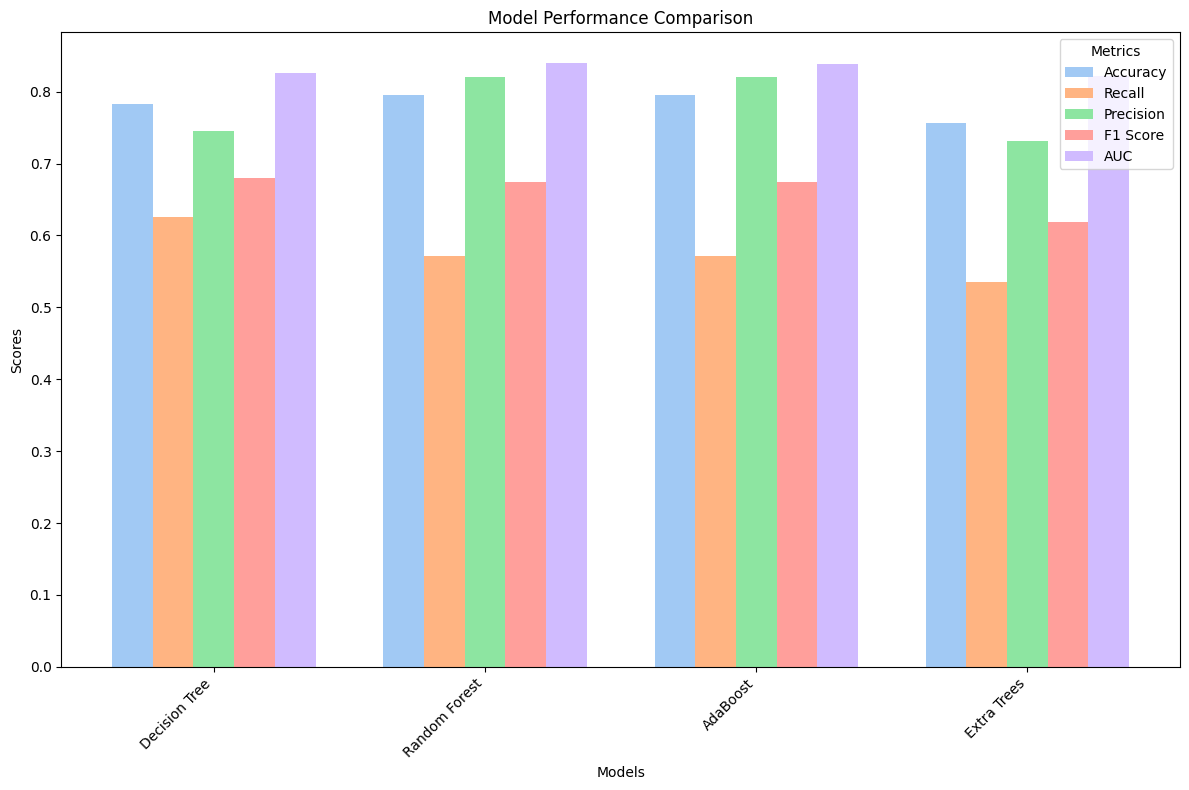

In [12]:
# Define the chart metrics and models
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
models = results_df['Model Name']
n_metrics = len(metrics)
n_models = len(models)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bar width and positions for each group
bar_width = 0.15
index = np.arange(n_models)

# Use Seaborn's color palette for pastel colors
colors = sns.color_palette("pastel", n_colors=n_metrics)

# Plot each metric for each model side by side with pastel colors
for i, (metric, color) in enumerate(zip(metrics, colors)):
    metric_values = results_df[metric]
    ax.bar(index + i * bar_width, metric_values, bar_width, label=metric, color=color)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(title="Metrics")

plt.tight_layout()
plt.show()

#### Visualization of the Decision Tree Structure

To gain a deeper understanding of how the tree-based algorithm makes decisions, we visualize the structure of the best-performing decision tree. This visualization provides insight into the feature splits that the model uses to classify outcomes, offering an explanation of the patterns associated with favorable ("Good") and unfavorable ("Bad") outcomes. By examining the tree structure, we can observe how different features influence the model’s decisions and identify common traits among predictions.


In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Find the index of the Decision Tree model
model_index = results['Model Name'].index("Decision Tree")

# Retrieve the Decision Tree model instance
decision_tree_model = results['Model Instance'][model_index]

# Visualize the Decision Tree
plt.figure(figsize=(200, 100))
plot_tree(decision_tree_model, filled=True, feature_names=X_tree.columns, class_names=['Bad', 'Good'], rounded=True)
plt.title("Visualization of the Decision Tree Model")
plt.show()


## 4. Distance-Based Models

In our approach to predicting patient outcomes, we utilize several distance-based models to leverage their unique strengths in binary classification tasks. Each model provides distinct advantages that make it suitable for healthcare applications, where both accuracy and interpretability are often key requirements.

### Models Overview

1. **Logistic Regression**
   - **Objective**: Logistic Regression is used here for its effectiveness in binary classification, particularly when interpretability is a priority.
   - **Why Choose Logistic Regression?**
     - **Linear Model**: It assumes a linear relationship between features and the target, capturing basic patterns effectively.
     - **Interpretability**: Logistic Regression coefficients are easy to understand, making it an ideal choice for healthcare, where model transparency is essential.
     - **Efficiency**: As a computationally inexpensive model, Logistic Regression is well-suited for larger datasets.

2. **Support Vector Machine (SVM)**
   - **Objective**: SVM is included to predict patient outcomes in cases where data is complex or non-linearly separable.
   - **Why Choose SVM?**
     - **Effective for Complex Data**: SVM can handle complex, high-dimensional data and supports different kernel functions to capture non-linear relationships.
     - **Robust to Overfitting**: With proper tuning, SVM generalizes well, making it particularly useful for high-stakes predictions like patient outcomes.
     - **Flexible Kernels**: Options like `linear` and `rbf` kernels allow SVM to adapt to a variety of data types and patterns.

3. **XGBoost (Extreme Gradient Boosting)**
   - **Objective**: XGBoost is used for its flexibility and accuracy, especially suited for complex datasets where feature interactions are significant.
   - **Why Choose XGBoost?**
     - **Performance on Complex Data**: XGBoost is designed for high accuracy and can handle complex feature interactions, making it ideal for patient outcome prediction.
     - **Efficiency**: It is optimized for speed and performance, which is beneficial for larger datasets or when real-time predictions are needed.
     - **Non-linear Relationship Handling**: XGBoost captures non-linear relationships, a valuable feature in healthcare data where patterns are often complex.

4. **k-Nearest Neighbors (k-NN)**
   - **Objective**: k-NN is included to capture patterns based on proximity, which can be helpful for detecting clusters in patient data.
   - **Why Choose k-NN?**
     - **Instance-based Learning**: k-NN makes predictions based on the similarity to other instances, allowing for a localized approach to classification.
     - **Interpretability**: Each prediction is based on a defined neighborhood, making it straightforward to explain predictions within the context of similar cases.
     - **Flexible Distance Metrics**: With options like `euclidean` and `manhattan` distance, k-NN is adaptable to different data distributions.

### Purpose of GridSearchCV in Model Optimization

To optimize these models, we use **GridSearchCV**, which systematically searches through combinations of hyperparameters to identify the optimal configuration for each model. This process enhances model performance by tuning parameters such as regularization strength, kernel type, number of neighbors, and learning rate.

- **Automated Hyperparameter Tuning**: GridSearchCV allows for efficient tuning by exploring a defined parameter grid.
- **Cross-Validation**: With 5-fold cross-validation (`cv=5`), we ensure robust model evaluation, minimizing the risk of overfitting and improving generalization.

By leveraging the strengths of these distance-based models, we aim to identify the most accurate and interpretable model for predicting patient outcomes, providing insights that are both clinically valuable and actionable.


In [14]:
# Define parameter grids for each distance-based model
distance_model_grids = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs'],
            'penalty': ['l2'],
            'max_iter': [200, 300, 500]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'probability': [True]  # Enables probability estimates for AUC
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'k-NN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}


In [15]:
# Loop through each model and apply GridSearchCV
for model_name, model_info in distance_model_grids.items():
    print(f"Training and optimizing {model_name}...")

    # Set up GridSearchCV
    start_time = time.time()
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_tree_train, y_train)
    training_time = time.time() - start_time

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Measure prediction time
    start_time = time.time()
    y_pred = best_model.predict(X_tree_test)
    prediction_time = time.time() - start_time

    # Get prediction probabilities for AUC calculation if available
    y_pred_proba = best_model.predict_proba(X_tree_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Append results to the existing results dictionary
    results['Model Name'].append(model_name)
    results['Model Instance'].append(best_model)
    results['Accuracy'].append(accuracy)
    results['Recall'].append(recall)
    results['Precision'].append(precision)
    results['F1 Score'].append(f1)
    results['AUC'].append(auc)
    results['Training Time (s)'].append(training_time)
    results['Prediction Time (s)'].append(prediction_time)

    # Print best parameters and current results
    print(f"Best {model_name} parameters:", grid_search.best_params_)
    results_df = pd.DataFrame(results)

# Final Results DataFrame with all models
print("\nFinal Results Table with Tree-Based and Distance-Based Models:")
print(results_df)

Training and optimizing Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Logistic Regression parameters: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
Training and optimizing SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best SVM parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}
Training and optimizing XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Training and optimizing k-NN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best k-NN parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}

Final Results Table with Tree-Based and Distance-Based Models:
            Model Name                                     Model Instance  \
0        Decision Tree  DecisionTreeClassifier(min_samples_leaf=4, ran...   
1        Ra

c:\Users\kentf\OneDrive\Studium\M.Sc.Med. Health Informatics\01 Modules\5HI024 - Research\00_Project\Resus_TTM\env_ttm\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


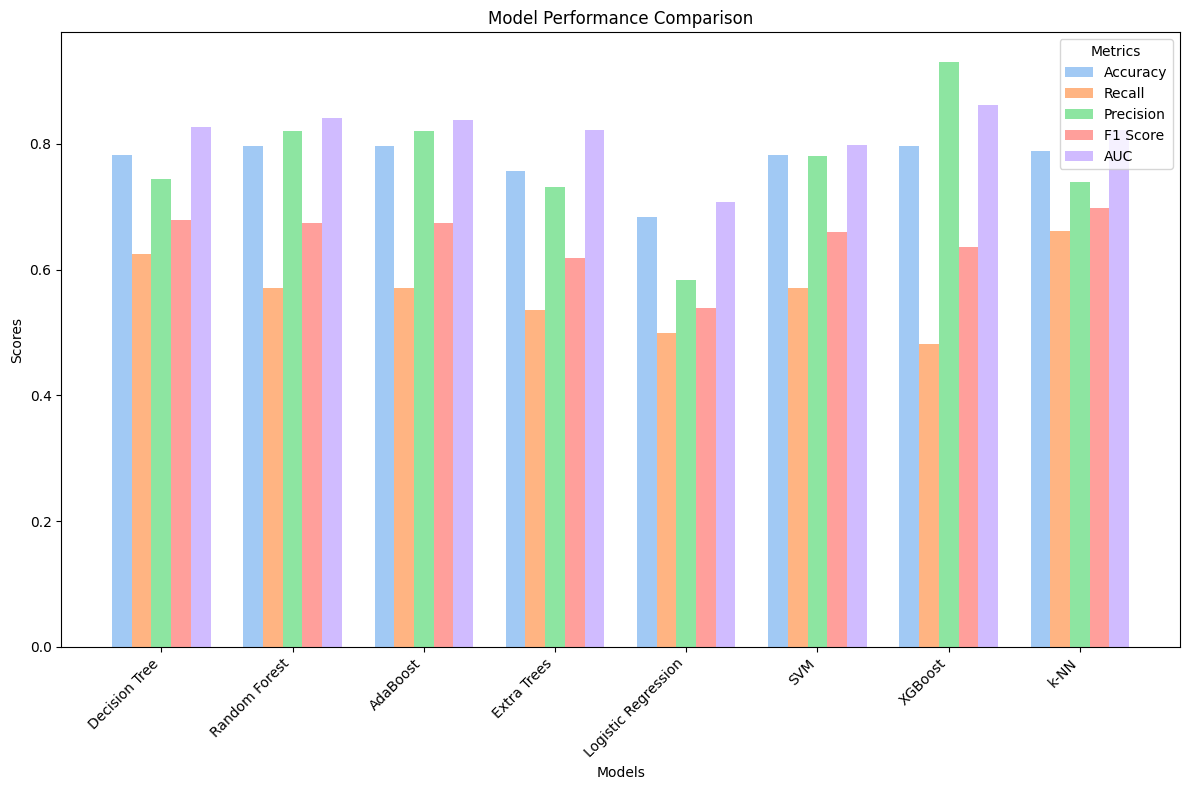

In [16]:
# Define the chart metrics and models
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
models = results_df['Model Name']
n_metrics = len(metrics)
n_models = len(models)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bar width and positions for each group
bar_width = 0.15
index = np.arange(n_models)

# Use Seaborn's color palette for pastel colors
colors = sns.color_palette("pastel", n_colors=n_metrics)

# Plot each metric for each model side by side with pastel colors
for i, (metric, color) in enumerate(zip(metrics, colors)):
    metric_values = results_df[metric]
    ax.bar(index + i * bar_width, metric_values, bar_width, label=metric, color=color)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(title="Metrics")

plt.tight_layout()
plt.show()